# scikit-learn - Regression - 0
 >__Created__:  17 October 2019, Bari, Italy     Harrison B. Prosper
  

### Introduction to Neural Networks
A neural network (NN) is a highly non-linear function. The functional form of a single layer fully-connected NN with $I$ inputs and $J$ outputs is

$$y_{j}(x) = f\left(b_{j} + \sum_{i=1}^I w_{ji} \, x_i\right),\quad j = 1,\cdots,J,$$
which in matrix notation is
$$\mathbf{y} = f\left(\mathbf{b} + \mathbf{w} \, \mathbf{x}\right),$$
where $f(*)$ is a function applied *element-wise* to its matrix argument, that is, applied to every element of the matrix. The function $f(*)$ is called an __activation__ function. Popular examples of the $f(*)$ are

\begin{align*}
    f(z) & = \tanh{z},\\
    f(z) & = \max(0, z) \quad\textrm{relu function}.
\end{align*}

Consider a neural network with $I$ inputs, $x_{i}, i = 1, \cdots, I$, a single hidden layer with $H$ nodes, and $K$ outputs $y_{k}(x), k = 1, \cdots, K$. Such a network is said to be *shallow* with structure $(I, H, K)$. The functional form is

$$y = g(\mathbf{b}_1 + \mathbf{w}_1 \, f(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x})),$$

where the subscripts label the layers, and, usually, the output function $g$ differs from $f$. For regression,  $g$ is
the $identity$ function. For 2-class (i.e., binary) classification it is usually the $logistic$ function 

$$g(z) = \frac{1}{1 + \exp(-z)},$$ 

while for multi-class classification one typically uses the $softwmax$ function

$$y_k = g(z_k) = \frac{\exp(z_k)}{\sum_{j=1}^K \exp(z_j)}.$$ 

For the special case of a single output network, $\mathbf{b}_1$ becomes a scalar $b$ and $\mathbf{w}_1$ 
is a column matrix.

### Deep Neural Networks
A deep neural network (DNN) model, of which many have been invented, is a recursively constructed function with two or more layers.  Indeed, it seems that there are as  many DNN models as there are machine learning researchers! This makes it difficult to give a single high-level view of all of the models. However, many feed-forward models (those in which information flows from the input to the output only) do have the same general structure. 
For example, a DNN with two hidden layers has the functional form

$$y = g(\mathbf{b}_2 + h_2(\mathbf{w}_2, \, f_2(\mathbf{b}_1 + h_1(\mathbf{w}_1, \, f_1(\mathbf{b}_0 + h_0(\mathbf{w}_0, \, \mathbf{x})))))),$$

where $g$, $h$ and $f$ are functions that implement a variety of mathematical operations, including matrix multiplication, non-linear transformations, max-pooling and cross-correlation, depending on the model. Some of these operations will be described in the pytorch tutorials.

### Exercise
  Build a network, using __MLPRegression__, to model supernova data from http://supernova.lbl.gov/Union/.

In [2]:
# system modules
import os, sys

# table manipulations
import pandas as pd

# array manipulations
import numpy as np

# scikit-learn modules
import sklearn as sk

#  split data into a training set and a test set
from sklearn.model_selection import train_test_split

#  a NN model whose output is the identity and 
#  which is therefore suitable for regression
from sklearn.neural_network import MLPRegressor

#  a function to save results
import joblib as jb

# plotting
import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

# display all plots inline (that is, just below the code that makes them)
%matplotlib inline

In [3]:
# setup desired fonts
FONTSIZE = 18
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

### Load data into memory

In [4]:
# ---------------------------------------------------------
# read Type Ia data
# format: name, z, y, dy
# name:     name of supernova
# z         measured redshift of supernova
# y +/- dy: measured distance modulus
# ---------------------------------------------------------
def readData(filename):
    import os
    from array import array

    if not os.path.exists(filename):
        sys.exit("** can't open file %s" % filename)
        
    # use (or perhaps abuse!) list comprehension.
    # skip first 5 lines, split each line, and 
    # convert elements 1, 2, and 3 to floats
    data= [ [float(x) for x in split_line[1:]] 
           for split_line in [str.split(line) 
                      for line in open(filename).readlines()[5:]] ]   
    z  = []
    y  = []
    dy = []
    ndata = len(data)
    for ii, d in enumerate(data):
        z.append(d[0])
        y.append(d[1])
        dy.append(d[2])
        
    # compute weight 1/standard-dev**2 using
    # numpy. the key thing about numpy is that there is an
    # implied loop in numpy expression that is executed 
    # much, much, faster than a Python loop.
    dy = np.array(dy)
    # the following expressions are applied to every element
    # of the numpy list
    w  = 1.0/dy**2
    w  = w / sum(w)
    
    # create a pandas table (a DataFrame)
    df = pd.DataFrame({'z': z, 
                       'y': y, 
                       'dy': dy, 
                       'weight': w})
    return df

In [5]:
dfe = readData('../datasets/SCPUnion2.1_mu_vs_z.txt')
print(len(dfe))

580


### Plot Type1a Supernova Data

In [6]:
def plotData(df, filename, dnn=None, fgsize=(9, 6)):
    z = df.z   # redshifts
    y = df.y   # distance moduli
    dy= df.dy  # distance moduli uncertainties
    
    # set up figure size, etc.
    plt.figure(figsize=fgsize)
    
    # plot points with error bars
    plt.errorbar(z, y, zorder=0, yerr=dy, fmt='o')
    
    # range of redshifts
    xmin =  0.0
    xmax =  1.6
    
    # range of distance moduli
    ymin = 32.0
    ymax = 48.0
    
    if dnn:
        # a neural network has been given so do following
        
        # create a uniformly space array of redshifts.
        # apparently, we need to reshape the array as shown.
        # note: the -1 means the length of the first dimension 
        # of the array is unspecified.
        x = np.arange(xmin, xmax, 0.02).reshape(-1, 1)
        
        # given redshifts x, predict distance moduli f. again
        # there is an implied loop over the elements of x
        f = SCALE * dnn.predict(x)
        
        # plot curve f vs. x
        plt.plot(x, f, zorder=1, lw=3, color='red')
        
    # complete plot decoration
    plt.xlim([xmin+0.01, xmax])
    plt.ylim([ymin+0.01, ymax])
    plt.xlabel('redshift ($z$)')
    plt.ylabel('distance modulus ($y$)')
    plt.savefig(filename)
    plt.show()
    return

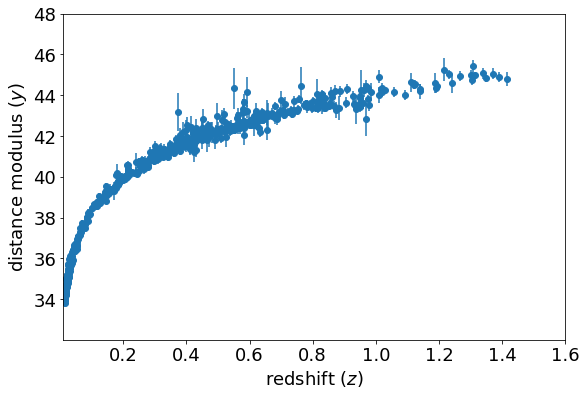

In [8]:
plotData(dfe, "scitkit-learn_exercise0_data.png")

### Train, validation, and test sets
There is some confusion in terminology regarding validation and test samples (or sets). We shall adhere to the defintions given here https://machinelearningmastery.com/difference-test-validation-datasets/):
   
  * __Training Dataset__: The sample of data used to fit the model.
  * __Validation Dataset__: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
  * __Test Dataset__: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

The validation set will be some small fraction of the training set and will be used to decide when to stop the training.

In [9]:
test_fraction  = 0.20
train_data0, test_data = train_test_split(dfe, test_size=test_fraction)
print(train_data0.shape)
print('train set size:      %4d' % train_data0.shape[0])
print('test set size:       %4d' % test_data.shape[0])
train_data0[:10]

(464, 4)
train set size:       464
test set size:        116


,z,y,dy,weight
426,0.949000,43.444910,0.284631,0.000635
446,0.449000,42.023068,0.157063,0.002086
139,0.015100,34.525875,0.213682,0.001127
238,0.119672,38.755538,0.110740,0.004196
113,0.049100,36.730136,0.175843,0.001664
482,0.218000,40.075407,0.222223,0.001042
121,0.017300,34.230066,0.220994,0.001054
62,0.022400,34.947087,0.239011,0.000901
222,0.248508,40.272175,0.125646,0.003259
298,0.216583,40.360272,0.152480,0.002213


### Balance training sample
The data for each supernova $i$ comes with a weight given $w_i = 1/\sigma_i^2/\sum_j 1/\sigma_j^2$, where $\sigma_i$ is the uncertainty in the measured distance modulus $y_i$. Since it appears that weights cannot be used with every model in scikit-learn, it is a bit ironic that we shall have to *unweight* the training data into to take account of the weights. Unweighting means creating a new sample so that an item with weight $w_i$ appears in the sample with a relative frequency proportional to $w_i$. For example, an item that has a weight 30% larger than another should appear 30% more often in the unweighted sample than the other item.

We'll do the unweighting using the binary bootstrap algorithm described below. One disadvantage of this method is that supernova entries will be repeated. Therefore, there will be some overlap between the training and validation data. The latter is used during the training in order to decide when the training should stop. However, the test data are not used during training.

#### Unweighting algorithm
In order to unweight data, we need to pick an item $i$, here the data associated with a supernova, with probability $p_i = w_i / w_s$, where $w_s = \sum_i w_i$ is the sum of the weights. The problem is analogous to throwing darts at a thin rectangular dart board marked with lines perpendicular to its length. The markings segment the board such that the distance between marks represents the weights. The length of the dart board, therefore, represents the sum of the weights $w_s$. Suppose that the darts are thrown at the board in such a way that they land on it in a uniform, but random, distribution. The number of darts in a given segment will be proportional to the length of the segment. Every time a dart is thrown, we record the segment number in which it lands and build a sample of segment numbers. The segment numbers can then be used to create the unweighted sample. Here is the algorithm, step by step.  
   1. Compute sum of weights $w_s = \sum_i w_i$.
   1. Generate a random number $u$ from a uniform distribution over the range $0 \mbox{ to } w_s$. (This determines where the dart lands.)
   1. Use a binary search to locate the segment in which $u$ lies.
   1. Repeat 2 and 3 as often as needed.
   
The reason this is called a bootstrap method is because it follows the bootstrap idea: approximate random sampling from a population (that is, an infinite sample) by sampling from a finite, but, one hopes, representative sample.  The key is to *sample with replacement*, that is, one takes an item at random from the (ideally, very large) sample, records the item's relevant characteristics, and place the item back in the sample so that the approximated population remains unchanged.

In [10]:
def bootstrap_unweight(df, factor=1.0, weightname='weight'):
    from math import sqrt
    from random import uniform
    
    # implement a binary search
    def binsearch(L, item):
        first = 0
        last  = len(L) - 1   
        found = False
        while (first <= last) and not found:
            mid = int((first + last) / 2)
            if item <= L[mid]:
                last = mid;       
            elif item > L[mid]:
                first = mid + 1
            if first >= last:
                mid = first
                found = True
        if found: return mid
        return -1

    w1 = df[weightname]
    w2 = w1*w1
    w1sum = sum(w1)
    w2sum = sum(w2)
    count = int(factor * w1sum*w1sum / w2sum)
    wcdf  = np.cumsum(w1)
    print("summed weight sum: %10.4f" % w1sum)
        
    wlist = wcdf.tolist()
    index = []
    for i in range(count):
        w = uniform(0, w1sum)
        k = binsearch(wlist, w)
        if k < 0 or k > len(wlist)-1:
            print("**error** location of weight %f not found" % w)
            return None
        index.append(k)
    return df.iloc[index]

In [11]:
# Artificially increase the number of points
train_data = bootstrap_unweight(train_data0, 25)
print(len(train_data))
train_data[0:5]

summed weight sum:     0.7977
7936


,z,y,dy,weight
293,0.143706,39.185771,0.116312,0.003804
428,0.370900,41.669204,0.154834,0.002146
402,0.470000,42.134559,0.153240,0.002191
576,1.315000,44.971358,0.187509,0.001463
243,0.251740,40.541722,0.118440,0.003668


### Prepare data
Make sure data are of order unity in magnitude. Apparently, it is necessary to reshape the data into 2-d arrays of shape (-1, 1).

In [12]:
SCALE = 50
train_x = train_data.z.values.reshape(-1, 1)
train_y = train_data.y.values.reshape(-1,) / SCALE

test_x  = test_data.z.values.reshape(-1, 1)
test_y  = test_data.y.values.reshape(-1,) / SCALE

### Define function space 
A particular choice of neural network architecture, shallow, deep, convolutional, recurrent, etc., defines the space of possible functions that can be accessed via training. If you get poor results, it could be because you have insufficient training data, or perhaps your function space does not contain a function that is a good approximation to the desired one, or it could be that your training algorithm is unable to locate the desired function within your function space, or any combination of these problems.

Here we use a $(1, 5, 3, 4, 1)$ network, that is, a network with one input, followed by three layers with 5, 3, and 4, nodes, respectively, and ending with a single output.

In [16]:
# Stop training when validation score is not improving. 
dnn = MLPRegressor(hidden_layer_sizes=(5,3,4), 
                    max_iter=10000, 
                    alpha=1e-5,
                    solver='adam',
                    activation='tanh',
                    verbose=0, 
                    tol=1e-12, 
                    warm_start=False,
                    random_state=1)

### Choose a function, aka train a regressor!

In [17]:
print("*** TRAINING ***")
dnn.fit(train_x, train_y)
       
print()
print("Training set score: %10.4f" % dnn.score(train_x, train_y))      
print("Test set score:     %10.4f" % dnn.score(test_x,  test_y))

filename = 'scikit-learn_exercise0_dnn.pkl'
print("save to %s" % filename)
jb.dump(dnn, filename)

*** TRAINING ***

Training set score:     0.9949
Test set score:         0.9889
save to scikit-learn_exercise0_dnn.pkl


['scikit-learn_exercise0_dnn.pkl']

### Plot loss curve vs. iterations
The loss function measures how *badly* the model fits the data; therefore, the smaller the loss function the better the fit. We use the default loss function, which for regression is

$$R(\mathbf{w}) = \frac{1}{N} \sum_{n=1}^N \left(y_n - f(x_n, \mathbf{w})\right)^2 .$$


In [18]:
def plotLoss(dnn, ftsize=FONTSIZE):
    y    = dnn.loss_curve_
    x    = np.array(range(len(y)))

    ymin = 1.e-6
    ymax = 1.0

    xmin = 0
    xmax = len(x)
    
    # set size of figure
    plt.figure(figsize=(8,4));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel('iteration', fontsize=ftsize)
    plt.ylabel('loss',  fontsize=ftsize)
    plt.yscale('log')
    plt.grid(True, which="both", linestyle='-')

    plt.plot(x, y)
    plt.savefig('scikit-learn_exercise0_dnn_loss.png')
    plt.show()

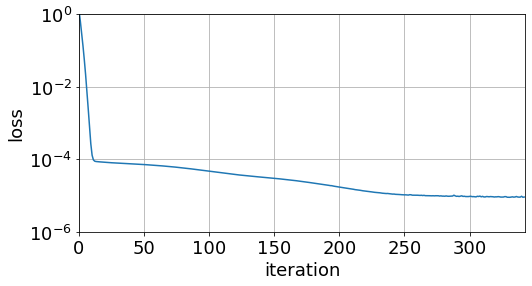

In [19]:
plotLoss(dnn)

### Plot results of fit

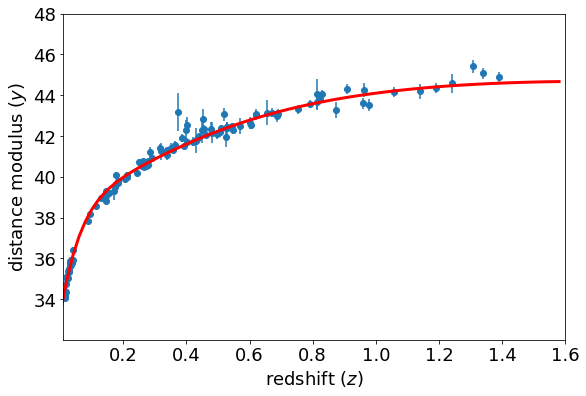

In [20]:
plotData(test_data, "scitkit-learn_exercise0_result.png", dnn)